In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5
N_ESTIMATORS = 100
MAX_DEPTH = 15
MIN_SAMPLES_SPLIT = 10
MIN_SAMPLES_LEAF = 5

# Directorio de salida
OUTPUT_DIR = "../../data/random-forest-output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*80)
print("MODELO DE RANDOM FOREST - HOME CREDIT DEFAULT RISK")
print("="*80)
print(f"\nTipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)")
print(f"Criterio de split: GINI (mide impureza para clasificación)")
print(f"Directorio de salida: {OUTPUT_DIR}")

MODELO DE RANDOM FOREST - HOME CREDIT DEFAULT RISK

Tipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)
Criterio de split: GINI (mide impureza para clasificación)
Directorio de salida: ../../data/random-forest-output


In [2]:
# =============================================================================
# 1. CARGA Y VERIFICACIÓN DE DATOS
# =============================================================================
print("\n[1/15] Cargando y verificando datos...")

df = pd.read_csv("../../data/processed/variables.csv")

print(f"Dataset cargado: {df.shape}")
print(f"Usuarios: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Tasa de default: {df['TARGET'].mean()*100:.2f}%")


[1/15] Cargando y verificando datos...
Dataset cargado: (307511, 41)
Usuarios: 307,511
Variables: 41
Tasa de default: 8.07%


In [3]:
# =============================================================================
# 2. PREPARACIÓN DE DATOS
# =============================================================================
print("\n[2/15] Preparando datos...")

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {y.name}")

numeric_vars = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars)}")
print(f"Variables categoricas: {len(categorical_vars)}")


[2/15] Preparando datos...
Variables predictoras: 39
Variable objetivo: TARGET
Variables numericas: 34
Variables categoricas: 5


In [ ]:
# =============================================================================
# 3. MANEJO DE VALORES FALTANTES
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
missing_vars = missing_pct[missing_pct > 0]

if len(missing_vars) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars)}")
    print(missing_vars.head(10))
    
    print("Imputando valores faltantes...")
    for col in numeric_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")


[3/15] Analizando valores faltantes...
Variables con valores faltantes: 10
TASA_INTERES_PROMEDIO    98.501192
RATIO_PAGO_MINIMO_TC     80.726218
EXT_SOURCE_1             56.381073
EXT_SOURCE_3             19.825307
PLAZO_PROMEDIO            5.485657
RATIO_PAGO_CUOTA          5.163718
EXT_SOURCE_2              0.214626
SCORE_PROMEDIO            0.055933
AMT_ANNUITY               0.003902
CNT_FAM_MEMBERS           0.000650
dtype: float64
Imputando valores faltantes...
Valores faltantes imputados


In [5]:
# =============================================================================
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders = {}

if len(categorical_vars) > 0:
    for col in categorical_vars:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print(f"{len(categorical_vars)} variables codificadas")
    print(f"Categorias: {categorical_vars}")



[4/15] Codificando variables categoricas...
5 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [6]:
# =============================================================================
# 5. DIVISIÓN TRAIN/TEST
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")



[5/15] Dividiendo datos en Train/Test...
Train set: 246,008 usuarios (80.0%)
Test set:  61,503 usuarios (20.0%)

Distribucion TARGET en Train:
  Clase 0 (Pago): 226,148 (91.93%)
  Clase 1 (Default): 19,860 (8.07%)


In [7]:
# =============================================================================
# 6. NOTA SOBRE NORMALIZACIÓN
# =============================================================================
print("\n[6/15] Nota sobre normalizacion...")

# Random Forest NO requiere normalización ya que es un modelo basado en árboles
# Los árboles de decisión son invariantes a transformaciones monótonas de las features
# Usamos los datos sin escalar para mejor interpretabilidad

print("Random Forest no requiere normalizacion de datos")
print("Los arboles de decision son invariantes a escalas de las variables")
print("Se usaran los datos originales (sin escalar)")



[6/15] Nota sobre normalizacion...
Random Forest no requiere normalizacion de datos
Los arboles de decision son invariantes a escalas de las variables
Se usaran los datos originales (sin escalar)


In [8]:
# =============================================================================
# 7. ENTRENAMIENTO DEL MODELO
# =============================================================================
print("\n[7/15] Entrenando Random Forest...")

model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)

print("\nModelo entrenado exitosamente")
print(f"Numero de arboles: {model.n_estimators}")
print(f"Profundidad maxima: {model.max_depth}")
print(f"Min samples split: {model.min_samples_split}")
print(f"Min samples leaf: {model.min_samples_leaf}")
print(f"Clases: {model.classes_}")



[7/15] Entrenando Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s



Modelo entrenado exitosamente
Numero de arboles: 100
Profundidad maxima: 15
Min samples split: 10
Min samples leaf: 5
Clases: [0 1]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.4s finished


In [9]:
# =============================================================================
# 8. VALIDACIÓN CRUZADA
# =============================================================================
print(f"\n[8/15] Validacion Cruzada ({CV_FOLDS}-fold en Train)...")

cv_scores = cross_val_score(
    model, X_train, y_train, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores}")
print(f"Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



[8/15] Validacion Cruzada (5-fold en Train)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Pa

ROC-AUC por fold: [0.74124295 0.7320359  0.74449844 0.7443346  0.74670445]
Media: 0.7418 (+/- 0.0052)


In [10]:
# =============================================================================
# 9. PREDICCIONES
# =============================================================================
print("\n[9/15] Generando predicciones...")

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Predicciones generadas")



[9/15] Generando predicciones...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Predicciones generadas


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [11]:
# =============================================================================
# 10. EVALUACIÓN EN TRAIN
# =============================================================================
print("\n[10/15] Evaluando modelo en TRAIN SET...")
print("="*80)

train_auc = roc_auc_score(y_train, y_train_proba)
train_ap = average_precision_score(y_train, y_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train_auc:.4f}")
print(f"Average Precision: {train_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_train[1,1]:,} - Predijo 'Default' y si hizo default")



[10/15] Evaluando modelo en TRAIN SET...

Metricas Globales:
ROC-AUC Score: 0.9222
Average Precision: 0.5242

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.98      0.87      0.92    226148
 Default (1)       0.36      0.78      0.49     19860

    accuracy                           0.87    246008
   macro avg       0.67      0.83      0.71    246008
weighted avg       0.93      0.87      0.89    246008


Confusion Matrix:
[[197868  28280]
 [  4282  15578]]

Interpretacion:
  Verdaderos Negativos (TN): 197,868 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 28,280 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 4,282 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 15,578 - Predijo 'Default' y si hizo default


In [12]:
# =============================================================================
# 11. EVALUACIÓN EN TEST
# =============================================================================
print("\n[11/15] Evaluando modelo en TEST SET (metricas definitivas)...")
print("="*80)

test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test_auc:.4f}")
print(f"Average Precision: {test_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_test[1,1]:,} - Predijo 'Default' y si hizo default")



[11/15] Evaluando modelo en TEST SET (metricas definitivas)...

Metricas Globales:
ROC-AUC Score: 0.7451
Average Precision: 0.2207

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.95      0.86      0.90     56538
 Default (1)       0.21      0.44      0.29      4965

    accuracy                           0.82     61503
   macro avg       0.58      0.65      0.59     61503
weighted avg       0.89      0.82      0.85     61503


Confusion Matrix:
[[48497  8041]
 [ 2777  2188]]

Interpretacion:
  Verdaderos Negativos (TN): 48,497 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 8,041 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 2,777 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 2,188 - Predijo 'Default' y si hizo default


In [13]:
# =============================================================================
# 12. COMPARACIÓN TRAIN VS TEST
# =============================================================================
print("\n[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train_auc:<12.4f} {test_auc:<12.4f} {abs(train_auc-test_auc):<12.4f}")
print(f"{'Average Precision':<25} {train_ap:<12.4f} {test_ap:<12.4f} {abs(train_ap-test_ap):<12.4f}")

diff_auc = abs(train_auc - test_auc)
if diff_auc < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")



[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...

Metrica                   Train        Test         Diferencia  
-----------------------------------------------------------------
ROC-AUC                   0.9222       0.7451       0.1771      
Average Precision         0.5242       0.2207       0.3035      

Overfitting detectado (diferencia > 10%)


In [14]:
# =============================================================================
# 13. IMPORTANCIA DE VARIABLES
# =============================================================================
print("\n[13/15] Calculando importancia de variables...")
print("="*80)

# Random Forest usa importancia basada en Gini (mean decrease in impurity)
# GINI se usa porque es un problema de CLASIFICACIÓN (predecir 0 o 1)
# - Gini mide la impureza de los nodos: que tan mezcladas están las clases
# - Un nodo "puro" tiene solo una clase (Gini = 0)
# - Un nodo con 50/50 tiene máxima impureza (Gini = 0.5 para binario)

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nTop 20 variables mas importantes para predecir default:\n")
print(feature_importance.head(20).to_string(index=False))

print("\nInterpretacion de importancia (Gini Importance):")
print("  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) o 1 (Default)")
print("  - Gini mide cuanto reduce cada variable la impureza en los splits")
print("  - Valores mas altos = mayor capacidad para separar las clases")
print("  - Basado en reduccion promedio de impureza en los 100 arboles")



[13/15] Calculando importancia de variables...

Top 20 variables mas importantes para predecir default:

               Variable  Importancia
         SCORE_PROMEDIO     0.183249
           EXT_SOURCE_2     0.095282
           EXT_SOURCE_3     0.094086
             DAYS_BIRTH     0.042976
              EDAD_ANOS     0.042558
           EXT_SOURCE_1     0.037583
       RATIO_PAGO_CUOTA     0.036051
            AMT_ANNUITY     0.035872
             AMT_CREDIT     0.034971
    CREDIT_INCOME_RATIO     0.033973
         PLAZO_PROMEDIO     0.031336
 TOTAL_CREDITO_OTORGADO     0.030732
TOTAL_CREDITO_HISTORICO     0.030321
  MONTO_PROMEDIO_PREVIO     0.030230
     TOTAL_DEUDA_ACTUAL     0.024201
     INGRESO_PER_CAPITA     0.023310
       AMT_INCOME_TOTAL     0.021557
      CREDITOS_CERRADOS     0.016803
   RATIO_PAGO_MINIMO_TC     0.016604
  NUM_PRESTAMOS_PREVIOS     0.016398

Interpretacion de importancia (Gini Importance):
  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) o 1 (Defau


[14/15] Generando visualizaciones...
Graficas guardadas: ../../data/random-forest-output/random_forest_curves.png


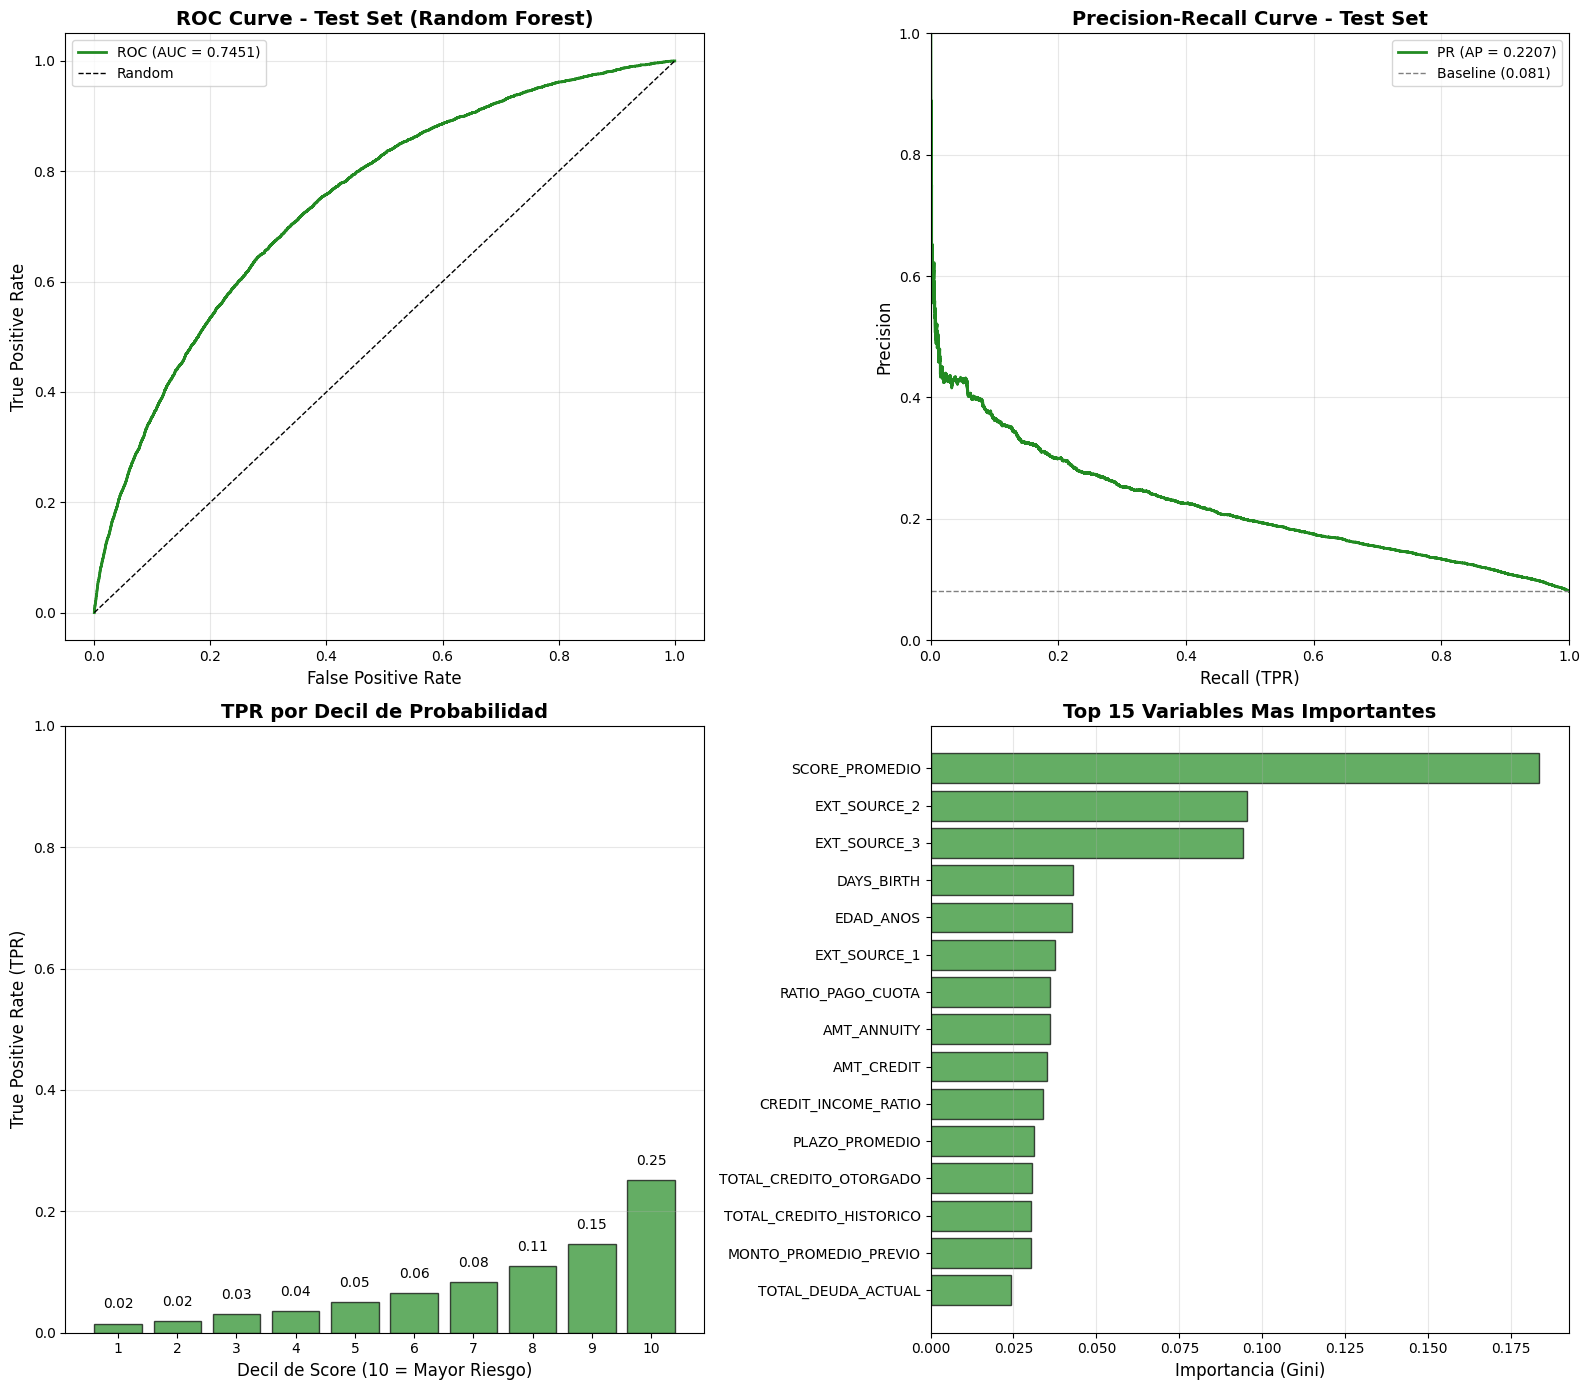


Tabla de TPR por Decil:
 decil  positivos  total      tpr
    10       1546   6151 0.251341
     9        899   6150 0.146179
     8        679   6150 0.110407
     7        510   6150 0.082927
     6        399   6150 0.064878
     5        309   6151 0.050236
     4        219   6150 0.035610
     3        191   6150 0.031057
     2        120   6150 0.019512
     1         93   6151 0.015119


In [15]:
# =============================================================================
# 14. VISUALIZACIONES
# =============================================================================
print("\n[14/15] Generando visualizaciones...")

# Calcular deciles
test_results = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba
})
test_results['decil'] = pd.qcut(test_results['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats = test_results.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats = decil_stats.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0, 0].plot(fpr, tpr, linewidth=2, color='forestgreen', label=f'ROC (AUC = {test_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve - Test Set (Random Forest)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)
sort_idx = np.argsort(recall)
recall_sorted = recall[sort_idx]
precision_sorted = precision[sort_idx]

axes[0, 1].plot(recall_sorted, precision_sorted, linewidth=2, color='forestgreen', label=f'PR (AP = {test_ap:.4f})')
axes[0, 1].axhline(y=y_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[0, 1].set_xlabel('Recall (TPR)', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# TPR por Decil
axes[1, 0].bar(decil_stats['decil'], decil_stats['tpr'], color='forestgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[1, 0].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1)

for i, row in decil_stats.iterrows():
    axes[1, 0].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

# Feature Importance (Top 15)
top_features = feature_importance.head(15)
axes[1, 1].barh(range(len(top_features)), top_features['Importancia'].values, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Variable'].values)
axes[1, 1].set_xlabel('Importancia (Gini)', fontsize=12)
axes[1, 1].set_title('Top 15 Variables Mas Importantes', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/random_forest_curves.png', dpi=300, bbox_inches='tight')
print(f"Graficas guardadas: {OUTPUT_DIR}/random_forest_curves.png")

plt.show()

# Imprimir tabla de deciles
print("\nTabla de TPR por Decil:")
print(decil_stats.to_string(index=False))


In [16]:
# =============================================================================
# 15. GUARDAR MODELO Y RESULTADOS
# =============================================================================
print("\n[15/15] Guardando modelo y resultados...")

with open(f'{OUTPUT_DIR}/random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open(f'{OUTPUT_DIR}/label_encoders_rf.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

feature_importance.to_csv(f'{OUTPUT_DIR}/feature_importance_rf.csv', index=False)

test_predictions = pd.DataFrame({
    'SK_ID_CURR': df.iloc[X_test.index]['SK_ID_CURR'].values,
    'TARGET_Real': y_test.values,
    'TARGET_Predicho': y_test_pred,
    'Probabilidad_Default': y_test_proba
})
test_predictions.to_csv(f'{OUTPUT_DIR}/test_predictions_rf.csv', index=False)

print(f"Archivos guardados en: {OUTPUT_DIR}/")
print("  - random_forest_model.pkl")
print("  - label_encoders_rf.pkl")
print("  - feature_importance_rf.csv")
print("  - test_predictions_rf.csv")
print("  - random_forest_curves.png")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n" + "="*80)
print("ANALISIS COMPLETADO - RANDOM FOREST")
print("="*80)
print(f"\nTipo de problema: CLASIFICACIÓN BINARIA")
print(f"  - Objetivo: Predecir si un cliente hará default (1) o pagará (0)")
print(f"  - Criterio de split: GINI (mide impureza para clasificación)")
print(f"\nResultados Finales (TEST SET):")
print(f"  ROC-AUC: {test_auc:.4f}")
print(f"  Average Precision: {test_ap:.4f}")
print(f"  Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"\nConfiguracion del modelo:")
print(f"  N_ESTIMATORS: {N_ESTIMATORS}")
print(f"  MAX_DEPTH: {MAX_DEPTH}")
print(f"  MIN_SAMPLES_SPLIT: {MIN_SAMPLES_SPLIT}")
print(f"  MIN_SAMPLES_LEAF: {MIN_SAMPLES_LEAF}")
print(f"\nArchivos guardados en: {OUTPUT_DIR}/")
print(f"\nEl modelo esta listo para produccion")
print("="*80)



[15/15] Guardando modelo y resultados...
Archivos guardados en: ../../data/random-forest-output/
  - random_forest_model.pkl
  - label_encoders_rf.pkl
  - feature_importance_rf.csv
  - test_predictions_rf.csv
  - random_forest_curves.png

ANALISIS COMPLETADO - RANDOM FOREST

Tipo de problema: CLASIFICACIÓN BINARIA
  - Objetivo: Predecir si un cliente hará default (1) o pagará (0)
  - Criterio de split: GINI (mide impureza para clasificación)

Resultados Finales (TEST SET):
  ROC-AUC: 0.7451
  Average Precision: 0.2207
  Accuracy: 0.8241

Configuracion del modelo:
  N_ESTIMATORS: 100
  MAX_DEPTH: 15
  MIN_SAMPLES_SPLIT: 10
  MIN_SAMPLES_LEAF: 5

Archivos guardados en: ../../data/random-forest-output/

El modelo esta listo para produccion
